In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import joblib

from utils import get_db_connection, clean_comment_text


### Download de stepwords

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Pré processamento e criação do dataframe

In [4]:
conn = get_db_connection()
query = 'SELECT * FROM lb_comments;'
df = pd.read_sql(query,conn)
conn.close()

C:\Users\marci\AppData\Local\Temp\ipykernel_16048\2065160649.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn)


In [5]:
df['label'] = df['classification'].map({'BOM' : 2, 'NEUTRO' : 1, 'RUIM' : 0})

In [6]:
df['comment_text'] = df['comment_text'].apply(clean_comment_text)

In [7]:
df = df[['comment_text', 'label']]

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['label'], test_size=0.2, random_state=42)

### Testes com 4 modelos de classificação

In [10]:
models = {
    'LogisticRegression': (LogisticRegression(), {
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__solver': ['liblinear'],
        'logisticregression__dual' : [False, True],
        'logisticregression__random_state' : [42],
    }),
    'RandomForestClassifier': (RandomForestClassifier(), {
        'randomforestclassifier__n_estimators': [25, 50, 100, 200, 225, 230, 300],
        'randomforestclassifier__max_depth': [None,5 , 10, 20],
        'randomforestclassifier__min_samples_split' : [2, 10, 20],
        'randomforestclassifier__min_samples_leaf' : [2, 10, 20],
        'randomforestclassifier__random_state' : [42],
    }),
    'SVC': (SVC(), {
        'svc__C': [0.1, 1, 10, 15, 20, 25],
        'svc__kernel': ['linear'],
        'svc__probability' : [True, False],
        'svc__gamma' : ['scale'],
        'svc__random_state' : [42] , 
    }),
    'NaiveBayes': (MultinomialNB(), {
        'naivebayes__alpha': [0.1, 0.5, 1.0]
        })
}
results = {}

---- LogisticRegression ----
              precision    recall  f1-score   support

         BOM       0.75      0.94      0.83        66
      NEUTRO       0.72      0.53      0.61        43
        RUIM       0.91      0.80      0.85        49

    accuracy                           0.78       158
   macro avg       0.79      0.76      0.76       158
weighted avg       0.79      0.78      0.78       158

Melhores parametros: {'logisticregression__C': 10, 'logisticregression__dual': False, 'logisticregression__random_state': 42, 'logisticregression__solver': 'liblinear'}
Melhor F1 ponderado (cross-validation): 0.7537



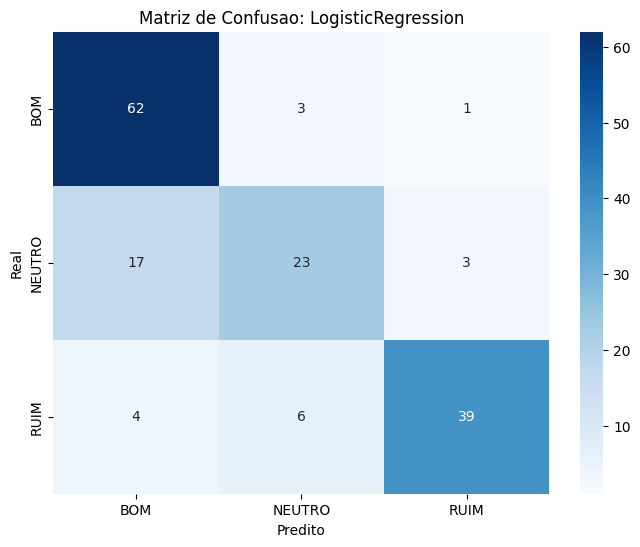

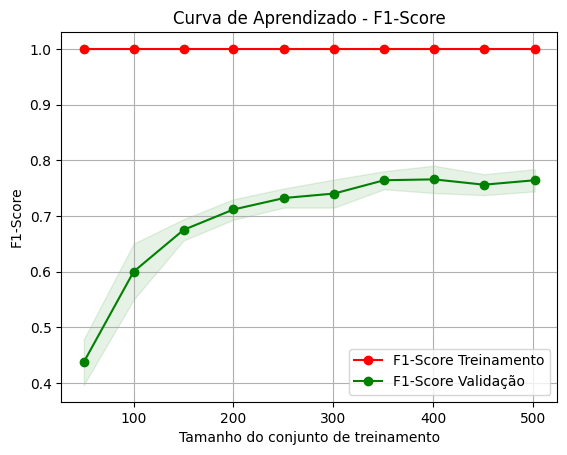

---- RandomForestClassifier ----
              precision    recall  f1-score   support

         BOM       0.79      0.67      0.72        66
      NEUTRO       0.57      0.37      0.45        43
        RUIM       0.58      0.88      0.70        49

    accuracy                           0.65       158
   macro avg       0.65      0.64      0.62       158
weighted avg       0.66      0.65      0.64       158

Melhores parametros: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 225, 'randomforestclassifier__random_state': 42}
Melhor F1 ponderado (cross-validation): 0.6751



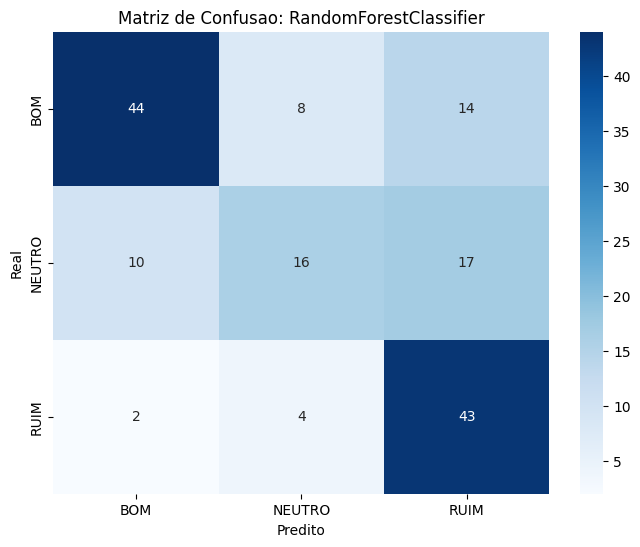

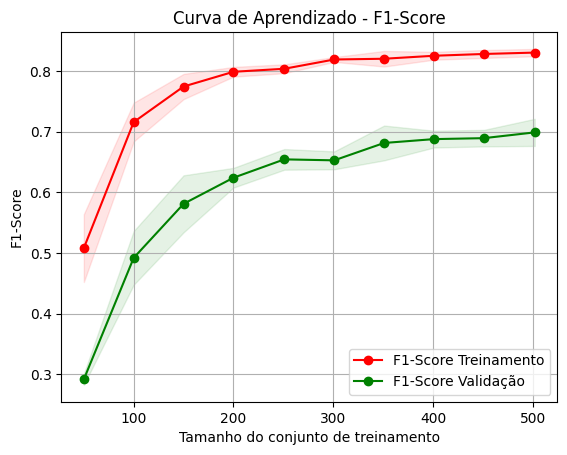

c:\Users\marci\OneDrive\Desktop\FIAP\POS\3 FASE\TC\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


---- SVC ----
              precision    recall  f1-score   support

         BOM       0.76      0.91      0.83        66
      NEUTRO       0.68      0.58      0.62        43
        RUIM       0.90      0.78      0.84        49

    accuracy                           0.78       158
   macro avg       0.78      0.76      0.76       158
weighted avg       0.78      0.78      0.77       158

Melhores parametros: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__probability': True, 'svc__random_state': 42}
Melhor F1 ponderado (cross-validation): 0.7559



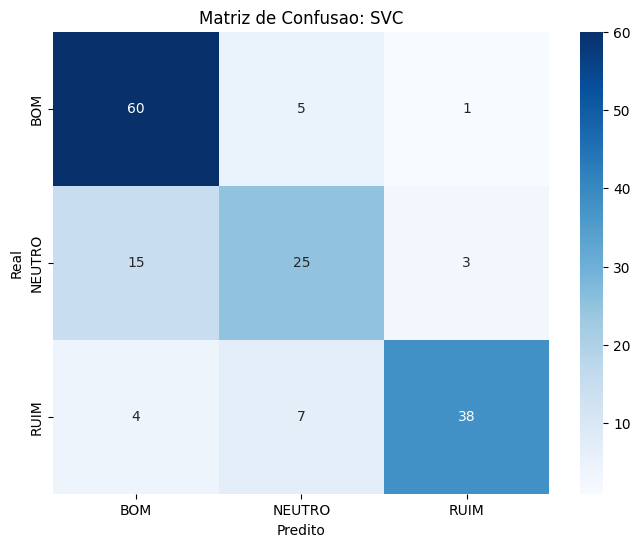

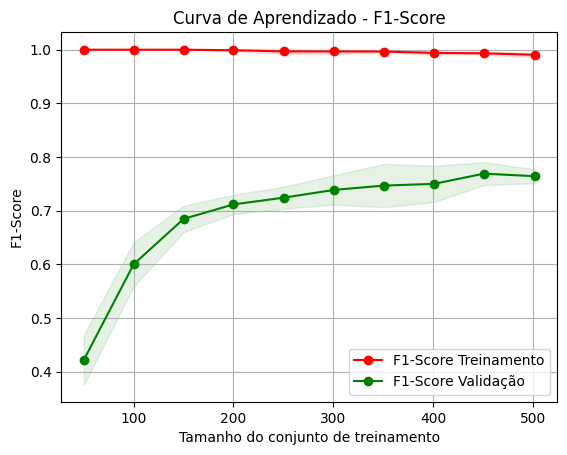

---- NaiveBayes ----
              precision    recall  f1-score   support

         BOM       0.62      0.94      0.75        66
      NEUTRO       0.68      0.44      0.54        43
        RUIM       0.90      0.55      0.68        49

    accuracy                           0.68       158
   macro avg       0.73      0.64      0.66       158
weighted avg       0.72      0.68      0.67       158

Melhores parametros: {'naivebayes__alpha': 0.1}
Melhor F1 ponderado (cross-validation): 0.6891



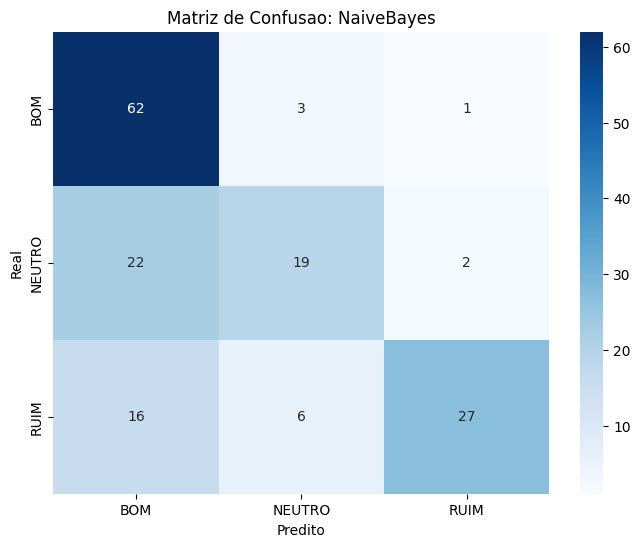

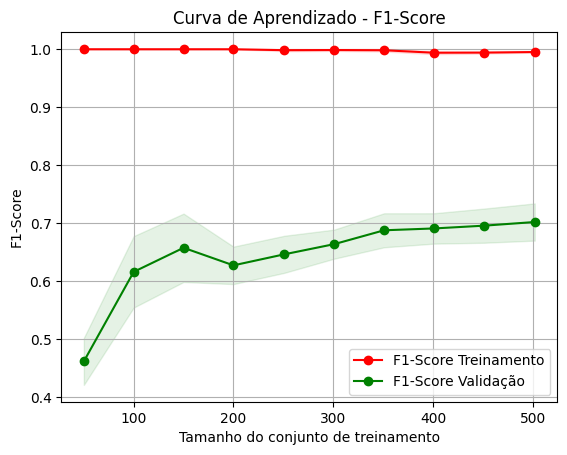

In [11]:
for model_name, (model, params) in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words = stopwords.words('portuguese'), analyzer='word') ) ,
        (model_name.lower(), model)
    ])
    
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1_weighted')
    
    grid_search.fit(X_train, y_train)

    results[model_name] = grid_search
    
    # ------------------ CLASSIFICATION REPORT
    y_pred = grid_search.predict(X_test)
    print(f'---- {model_name} ----')
    print(classification_report(y_test, y_pred, target_names=['BOM', 'NEUTRO', 'RUIM']))
    print(f'Melhores parametros: {grid_search.best_params_}')
    print(f'Melhor F1 ponderado (cross-validation): {grid_search.best_score_:.4f}\n')
    
    # ------------------- MATRIZ DE CONFUSÃO
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BOM', 'NEUTRO', 'RUIM'], yticklabels=['BOM', 'NEUTRO', 'RUIM'])
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.title(f'Matriz de Confusao: {model_name}')
    plt.show()
    
    # -------------------- CURVA DE APRENDIZAGEM
    train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, 
                                                            cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Curva de Aprendizado - F1-Score")
    plt.xlabel("Tamanho do conjunto de treinamento")
    plt.ylabel("F1-Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="F1-Score Treinamento")

    # Plotando os resultados de validação
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="F1-Score Validação")

    plt.legend(loc="best")
    plt.show()
    

In [12]:
joblib.dump(grid_search.best_estimator_, './utils/best_model.pkl')

['./utils/best_model.pkl']